In [2]:
!pip install -U gym box2d-py > /dev/null 2>&1
#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?
ln: failed to create symbolic link '/usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so': Permission denied
E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


In [3]:
import gym
import random
import copy
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from tqdm import tqdm

from IPython.display import clear_output
import os
import pickle
path_to_project = 'storage/'

In [4]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
Continuous version by Ian Danforth
"""

import math
from gym import spaces, logger
from gym.utils import seeding

class ContinuousCartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = 0.02  # seconds between state updates
        self.min_action = -1.0
        self.max_action = 1.0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 15 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            shape=(1,)
        )
        self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        assert self.action_space.contains(action), \
            "%r (%s) invalid" % (action, type(action))
        # Cast action to float to strip np trappings
        force = self.force_mag * float(action)
        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state
        done = x < -self.x_threshold \
            or x > self.x_threshold \
            or theta < -self.theta_threshold_radians \
            or theta > self.theta_threshold_radians
        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("""
                You are calling 'step()' even though this environment has already returned
                done = True. You should always call 'reset()' once you receive 'done = True'
                Any further steps are undefined behavior.
                """)
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width /world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen-polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=(mode == 'rgb_array'))

    def close(self):
        if self.viewer:
            self.viewer.close()

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


BUFFER_SIZE = int(5e4)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 1e-3        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, gamma=GAMMA, tau=TAU,
                 actor_fc1_units=400, actor_fc2_units=300, actor_lr=LR_ACTOR, 
                 critic_fc1_units=400, critic_fc2_units=300, critic_lr=LR_CRITIC, 
                 weight_decay=WEIGHT_DECAY, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=actor_lr)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, critic_fc1_units, critic_fc2_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, critic_fc1_units, critic_fc2_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=critic_lr, weight_decay=weight_decay)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_targets, Q_expected)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
def ddpg(env, agent, n_episodes=1500, max_t=200, print_every=100, score_threshold=200):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if (np.mean(scores_deque) >= score_threshold): break
    
    return scores


def ddpg_with_testing(env, agent, n_episodes=1500, max_t=200, n_test_episodes=10, test_freq=100, 
                      clear_freq=300, score_threshold=200):
    scores_deque = deque(maxlen=100)
    scores = []
    test_scores = []
    
    max_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        # pdb.set_trace()
        if i_episode % clear_freq == 0:
            clear_output()
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
            if i_episode % test_freq != 0:
                print('')
            
        if i_episode % test_freq == 0:
            print('')
            test_scores_deque = deque(maxlen=100)
            test_scores_per_episode = []
            for i_test_episode in range(1, n_test_episodes+1):
                test_agent = copy.copy(agent)
                state = env.reset()
                agent.reset()
                score = 0
                for t in range(max_t):
                    action = test_agent.act(state, add_noise=False)
                    next_state, reward, done, _ = env.step(action)
                    state = next_state
                    score += reward
                    if done:
                        break 
                test_scores_deque.append(score)
                test_scores_per_episode.append(score)
                print('\rTest Episode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_test_episode, np.mean(test_scores_deque), score), end="")
            test_scores.append(np.average(test_scores_per_episode))
            print('\nTest From Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(test_scores_deque))) 
            print('=================================================')
        
        if (np.mean(scores_deque) >= score_threshold): return scores, test_scores
            
    return scores, test_scores

# CartPole

In [7]:
cart_path = os.path.join(path_to_project, 'ddpg_cart_tasks')
data_path = os.path.join(cart_path, 'data')
models_path = os.path.join(cart_path, 'models')
plots_path = os.path.join(cart_path, 'plots')
class Variables:
    SEED=42
    BASELINE_CHECKPOINT_NAME=os.path.join(models_path, 'CartPole_baseline.pth')
    NUM_SEEDS=5
    NUM_TASKS=5
    NUM_EPISODES=1500

## Baseline

In [61]:
env = ContinuousCartPoleEnv()

env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

agent = Agent(state_size, action_size, random_seed=0, gamma=0.99, tau=0.005,
             actor_fc1_units=400, actor_fc2_units=300, actor_lr=1e-4,
             critic_fc1_units=400, critic_fc2_units=300, critic_lr=1e-3,
             weight_decay=0, buffer_size=int(2e6), batch_size=64)

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [62]:
scores, test_scores = ddpg_with_testing(env, agent, n_episodes=Variables.NUM_EPISODES, max_t=200, test_freq=50)

Episode 1200	Average Score: 199.88	Score: 200.00
Test Episode 10	Average Score: 200.00	Score: 200.00
Test From Episode 1200	Average Score: 200.00
Episode 1202	Average Score: 200.00	Score: 200.00

In [63]:
if len(scores) < Variables.NUM_EPISODES:
    diff = Variables.NUM_EPISODES - len(scores)
    last_reward = scores[-1]
    for _ in range(diff):
        scores.append(last_reward)

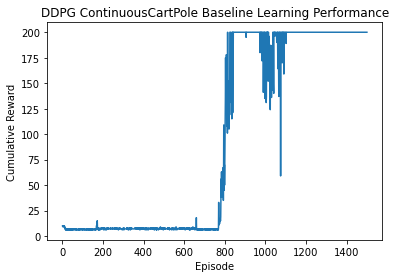

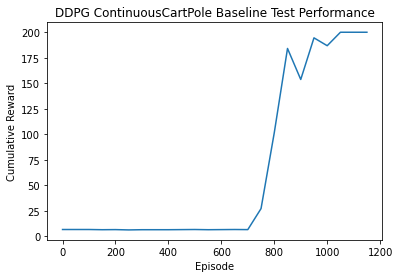

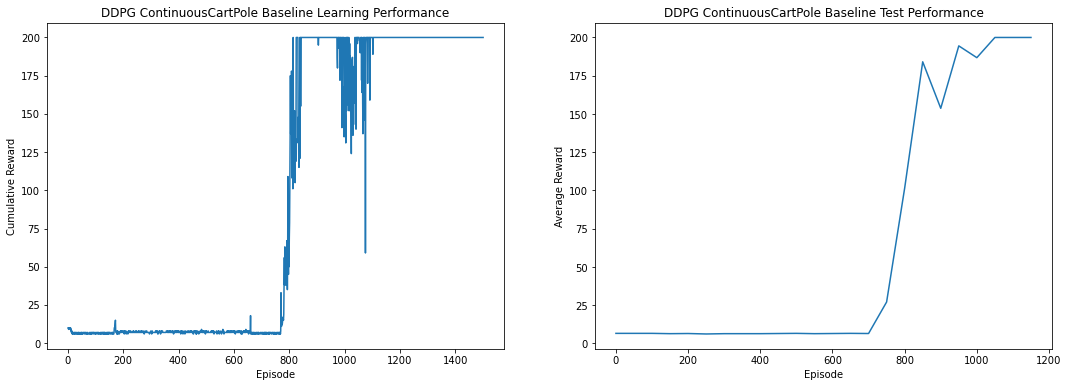

In [77]:
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('DDPG ContinuousCartPole Baseline Learning Performance')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

plt.plot([i * 50 for i in range(len(test_scores))], test_scores)
plt.title('DDPG ContinuousCartPole Baseline Test Performance')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.savefig(os.path.join(plots_path, 'baseline_test.png'))
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('DDPG ContinuousCartPole Baseline Learning Performance')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.subplot(122)
plt.plot([i * 50 for i in range(len(test_scores))], test_scores)
plt.title('DDPG ContinuousCartPole Baseline Test Performance')
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.savefig(os.path.join(plots_path, 'baseline_w_test.png'))
plt.show()

In [30]:
torch.save(agent.actor_local.state_dict(), os.path.join(models_path, 'actor_local.pth'))
torch.save(agent.actor_target.state_dict(), os.path.join(models_path, 'actor_target.pth'))
torch.save(agent.critic_local.state_dict(), os.path.join(models_path, 'critic_local.pth'))
torch.save(agent.critic_target.state_dict(), os.path.join(models_path, 'critic_target.pth'))

# New Tasks

In [8]:
def sample_cartpole_tasks(num_tasks, random_state, variable=None):
    if variable is not None:
        if variable == 'gravity':
            gravity = random_state.normal(loc=9.8, size=(num_tasks))
            tasks = [{'gravity': g} for g in gravity]

        elif variable == 'masscart':
            masscart = random_state.normal(loc=1.0, scale=0.25, size=(num_tasks))
            total_mass = np.array([m1 + 0.1 for m1 in masscart])
            tasks = [{'masscart': mc, 'total_mass': mt} for mc, mt in zip(masscart, total_mass)]

        elif variable == 'masspole':
            masspole = random_state.normal(loc=0.1, scale=0.025, size=(num_tasks))
            total_mass = np.array([m1 + 1.0 for m1 in masspole])
            tasks = [{'masspole': mp, 'total_mass': mt} for mp, mt, in zip(masspole, total_mass)]

        elif variable == 'length':
            length = random_state.normal(loc=0.5, scale=0.125, size=num_tasks)
            tasks = [{'length': l} for l in length]

        elif variable == 'polemass_length':
            polemass_length = random_state.normal(loc=0.05, scale=0.0125, size=num_tasks)
            tasks = [{'polemass_length': l} for l in polemass_length]
            
        elif variable == 'force_mag':
            force_mag = random_state.normal(loc=10, size=num_tasks)
            tasks = [{'force_mag': fg} for fg in force_mag]

        else:
            raise NotImplementedError(f"No such variable {variable}")
    else:
        # gravity = random_state.normal(loc=9.8, size=(num_tasks))
        masscart = random_state.normal(loc=1.0, scale=0.25, size=(num_tasks))
        masspole = random_state.normal(loc=0.1, scale=0.025, size=(num_tasks))
        total_mass = np.array([m1 + m2 for m1, m2 in zip(masscart, masspole)])
        length = random_state.normal(loc=0.5, scale=0.125, size=num_tasks)
        polemass_length = random_state.normal(loc=0.05, scale=0.0125, size=num_tasks)
        tasks = [{'masscart': mc, 'masspole': mp, 'total_mass': mt, 'length': l,
                    'polemass_length': pl} for mc, mp, mt, l, pl in zip(masscart, 
                    masspole, total_mass, length, polemass_length)]
    return tasks


def set_task(env, task):
    for k, v in task.items():
        env.__dict__[k] = v
    return env

In [9]:
env = ContinuousCartPoleEnv()

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

Variables.NUM_TASKS = 5
Variables.NUM_EPISODES = 1500
Variables.NUM_SEEDS = 2

random_state = np.random.RandomState(Variables.SEED)
tasks = sample_cartpole_tasks(Variables.NUM_TASKS, random_state)

history_transfer = []
history_scratch = []

test_history_transfer = []
test_history_scratch = []

average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for i, task in tqdm(enumerate(tasks), desc=f'Running {Variables.NUM_TASKS} tasks'):
    scores_transfer_per_seed = []
    scores_scratch_per_seed = []
    
    test_scores_transfer_per_seed = []
    test_scores_scratch_per_seed = []
    for seed in range(Variables.NUM_SEEDS):
        env.seed(seed)
        set_task(env, task)

        s_size = env.observation_space.shape[0]
        a_size = env.action_space.shape[0]

        # Transfer agent needs to load the weights for each new task
        agent_transfer = Agent(state_size, action_size, random_seed=0, gamma=0.99, tau=0.005,
                                 actor_fc1_units=400, actor_fc2_units=300, actor_lr=1e-4,
                                 critic_fc1_units=400, critic_fc2_units=300, critic_lr=1e-3,
                                 weight_decay=0, buffer_size=int(2e6), batch_size=64)

        agent_transfer.actor_local.load_state_dict(torch.load(os.path.join(models_path, 'actor_local.pth')))
        agent_transfer.actor_target.load_state_dict(torch.load(os.path.join(models_path, 'actor_target.pth')))
        agent_transfer.critic_local.load_state_dict(torch.load(os.path.join(models_path, 'critic_local.pth')))
        agent_transfer.critic_target.load_state_dict(torch.load(os.path.join(models_path, 'critic_target.pth')))
        
        scores_transfer, test_scores_transfer = ddpg_with_testing(env, agent_transfer, n_episodes=Variables.NUM_EPISODES, max_t=200, test_freq=50)
        
        scores_transfer_per_seed.append(scores_transfer)
        test_scores_transfer_per_seed.append(test_scores_transfer)

        # Agent from scratch has its weights initialized randomly for each new task
        agent_scratch = Agent(state_size, action_size, random_seed=0, gamma=0.99, tau=0.005,
                                 actor_fc1_units=400, actor_fc2_units=300, actor_lr=1e-4,
                                 critic_fc1_units=400, critic_fc2_units=300, critic_lr=1e-3,
                                 weight_decay=0, buffer_size=int(2e6), batch_size=64)
        
        scores_scratch, test_scores_scratch = ddpg_with_testing(env, agent_scratch, n_episodes=Variables.NUM_EPISODES, max_t=200, test_freq=50)
        
        scores_scratch_per_seed.append(scores_scratch)
        test_scores_scratch_per_seed.append(test_scores_scratch)

    history_transfer.append(scores_transfer_per_seed)
    history_scratch.append(scores_scratch_per_seed)
    
    test_history_transfer.append(test_scores_transfer_per_seed)
    test_history_scratch.append(test_scores_scratch_per_seed)

Episode 1200	Average Score: 8.61	Score: 9.00
Test Episode 10	Average Score: 98.10	Score: 94.00
Test From Episode 1200	Average Score: 98.10
Episode 1230	Average Score: 8.66	Score: 11.00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
for task_idx, task_ls in enumerate(history_transfer):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)

for task_idx, task_ls in enumerate(history_scratch):
    for seed_idx, seed_ls in enumerate(task_ls):
        if len(seed_ls) < Variables.NUM_EPISODES:
            diff = Variables.NUM_EPISODES - len(seed_ls)
            last_reward = seed_ls[-1]
            for i in range(diff):
                seed_ls.append(last_reward)
                
average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

for ls_transfer, ls_scratch in zip(history_transfer, history_scratch):

    average_transfer_per_task.append(np.average(ls_transfer, axis=0))
    variance_transfer_per_task.append(np.var(ls_transfer, axis=0))

    average_scratch_per_task.append(np.average(ls_scratch, axis=0))
    variance_scratch_per_task.append(np.var(ls_scratch, axis=0))
    

for task_idx, task_ls in enumerate(test_history_transfer):
    for seed_idx, test_seed_ls in enumerate(task_ls):
        if len(test_seed_ls) < Variables.NUM_EPISODES // 50:
            diff = Variables.NUM_EPISODES //50 - len(test_seed_ls)
            last_reward = test_seed_ls[-1]
            for i in range(diff):
                test_seed_ls.append(last_reward)

for task_idx, task_ls in enumerate(test_history_scratch):
    for seed_idx, test_seed_ls in enumerate(task_ls):
        if len(test_seed_ls) < Variables.NUM_EPISODES // 50:
            diff = Variables.NUM_EPISODES //50 - len(test_seed_ls)
            last_reward = test_seed_ls[-1]
            for i in range(diff):
                test_seed_ls.append(last_reward)
                
test_average_transfer_per_task = []
test_variance_transfer_per_task = []

test_average_scratch_per_task = []
test_variance_scratch_per_task = []

for ls_transfer, ls_scratch in zip(test_history_transfer, test_history_scratch):

    test_average_transfer_per_task.append(np.average(ls_transfer, axis=0))
    test_variance_transfer_per_task.append(np.var(ls_transfer, axis=0))

    test_average_scratch_per_task.append(np.average(ls_scratch, axis=0))
    test_variance_scratch_per_task.append(np.var(ls_scratch, axis=0))

In [11]:
plots_path = os.path.join(path_to_project, 'ddpg_cart_tasks/plots')
data_path = os.path.join(path_to_project, 'ddpg_cart_tasks/data')

save = False
if save:
    with open(os.path.join(data_path, 'history_transfer.list'), 'wb') as f:
        pickle.dump(history_transfer, f)
    with open(os.path.join(data_path,'history_scratch.list'), 'wb') as f:
        pickle.dump(history_scratch, f)
    with open(os.path.join(data_path, 'test_history_transfer.list'), 'wb') as f:
        pickle.dump(test_history_transfer, f)
    with open(os.path.join(data_path,'test_history_scratch.list'), 'wb') as f:
        pickle.dump(test_history_scratch, f)
    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'wb') as f:
        pickle.dump(average_transfer_per_task, f)
    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'wb') as f:
        pickle.dump(variance_transfer_per_task, f)
    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'wb') as f:
        pickle.dump(average_scratch_per_task, f)
    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'wb') as f:
        pickle.dump(variance_scratch_per_task, f)
    with open(os.path.join(data_path, 'tasks.list'), 'wb') as f:
        pickle.dump(tasks, f)
        
load = True
if load:
    with open(os.path.join(data_path, 'history_transfer.list'), 'rb') as f:
        history_transfer = pickle.load(f)

    with open(os.path.join(data_path,'history_scratch.list'), 'rb') as f:
        history_scratch = pickle.load(f)
        
    with open(os.path.join(data_path, 'test_history_transfer.list'), 'rb') as f:
        test_history_transfer = pickle.load(f)

    with open(os.path.join(data_path,'test_history_scratch.list'), 'rb') as f:
        test_history_scratch = pickle.load(f)

    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'rb') as f:
        average_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'rb') as f:
        variance_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'rb') as f:
        average_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'rb') as f:
        variance_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path, 'tasks.list'), 'rb') as f:
        tasks = pickle.load(f)

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


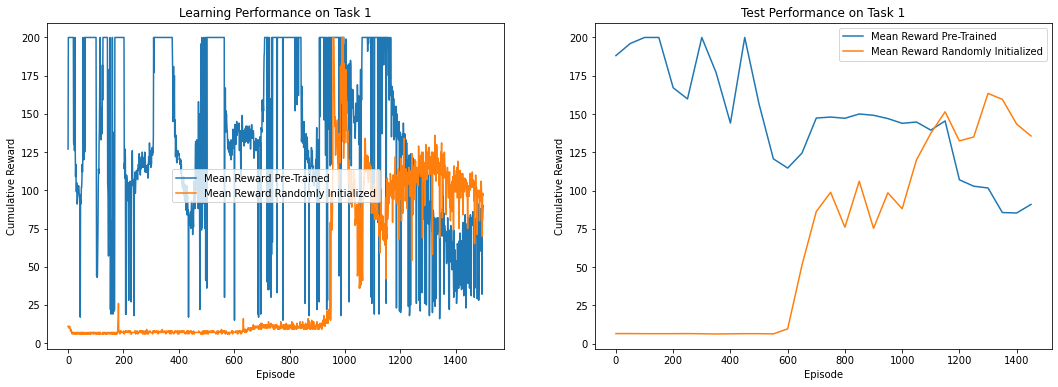

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


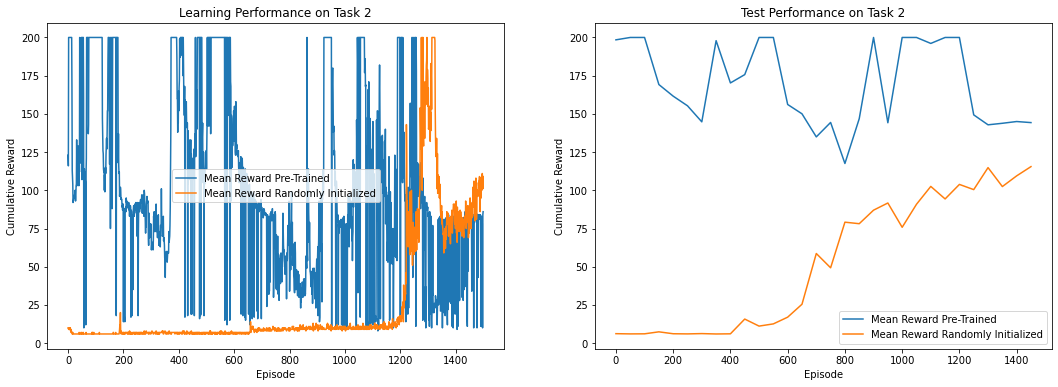

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


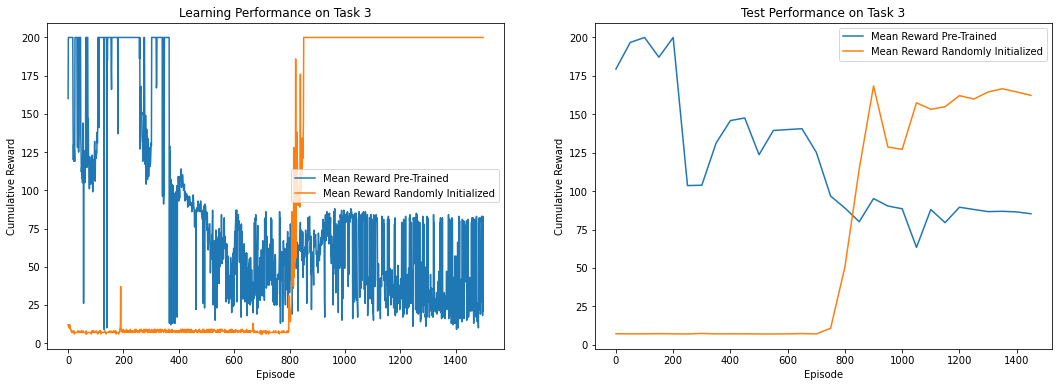

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


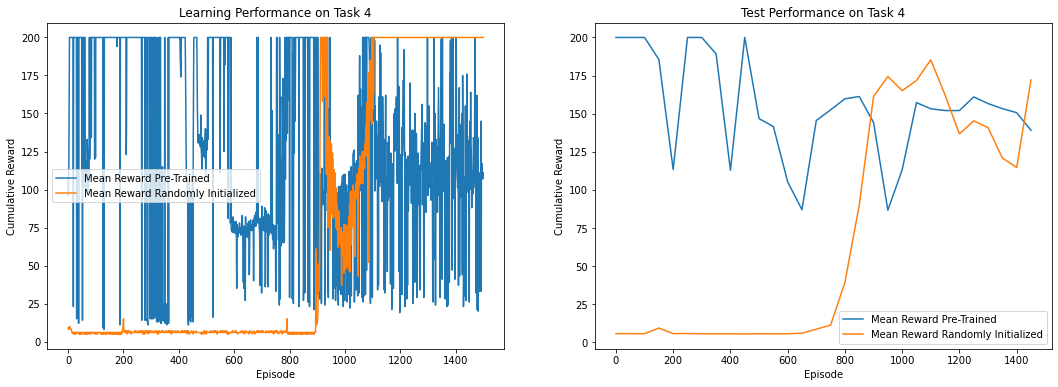

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


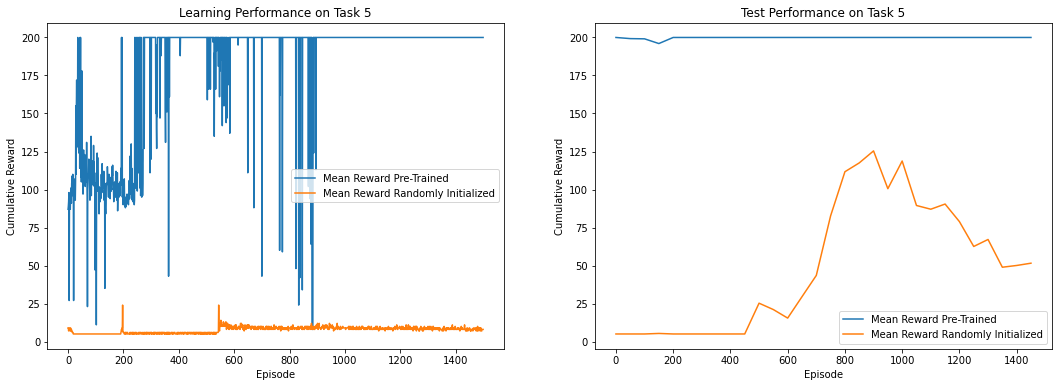

In [12]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])
    
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    average = average_transfer_per_task[i] 
    plt.plot(average)
    average = average_scratch_per_task[i] 
    plt.plot(average)
    
    plt.title(f"Learning Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'), loc=0)

    plt.subplot(122)
    average = test_average_transfer_per_task[i] 
    plt.plot([50 * i for i in range(len(average))] ,average)
    average = test_average_scratch_per_task[i] 
    plt.plot([50 * i for i in range(len(average))], average)
    plt.title(f"Test Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'), loc=0)
    plt.savefig(os.path.join(plots_path, f'task_{i+1}_w_test.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


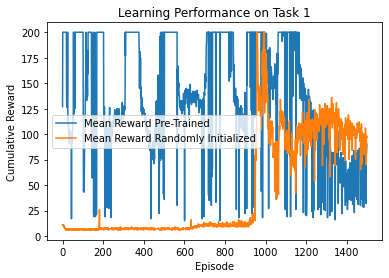

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


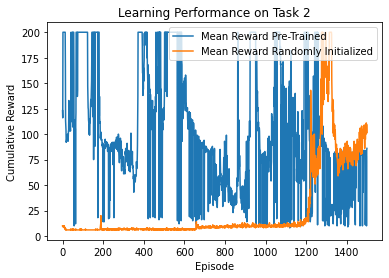

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


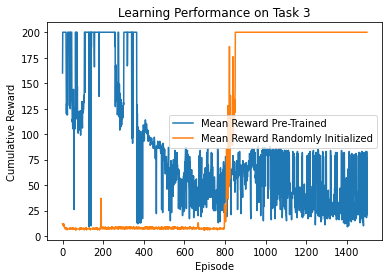

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


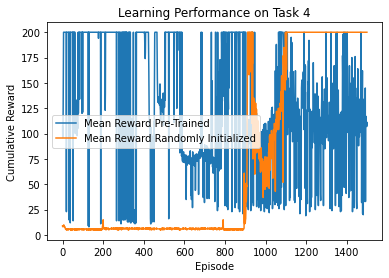

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


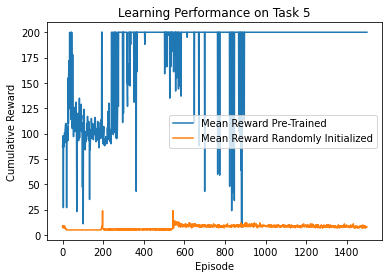

In [13]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    plt.plot(average)

    average = average_scratch_per_task[i] 
    plt.plot(average)

    print(tasks[i])
    plt.title(f"Learning Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'task_{i+1}.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


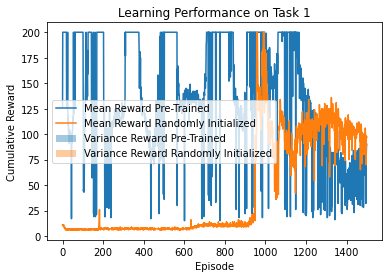

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


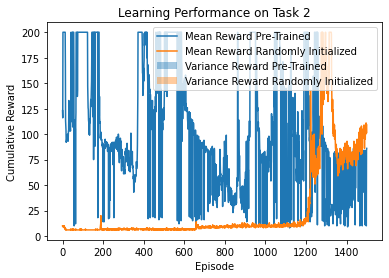

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


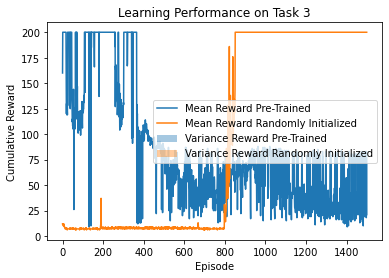

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


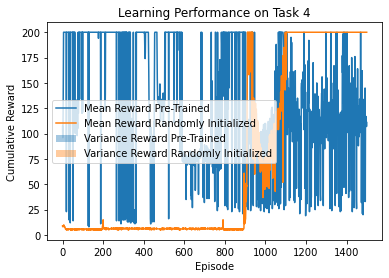

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


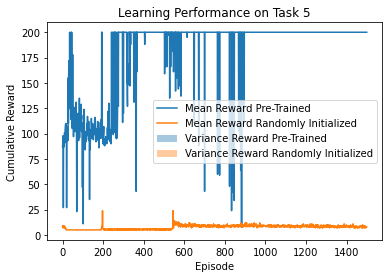

In [20]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]
    plt.plot(average)
    plt.fill_between(len(average), average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i] 
    plt.plot(average)
    plt.fill_between(len(average), average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Learning Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
               'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_task_{i+1}.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


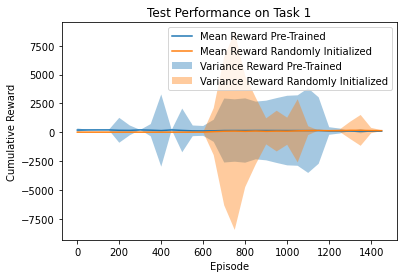

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


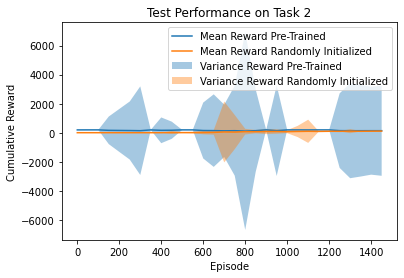

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


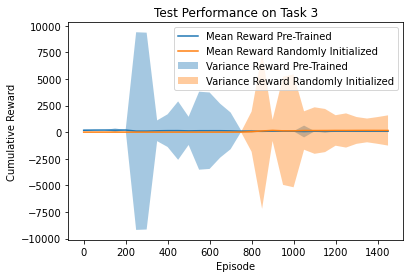

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


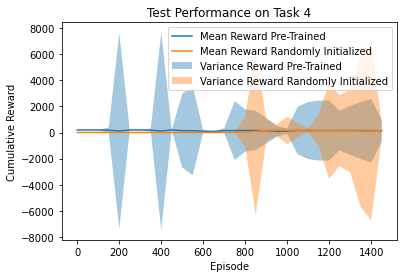

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


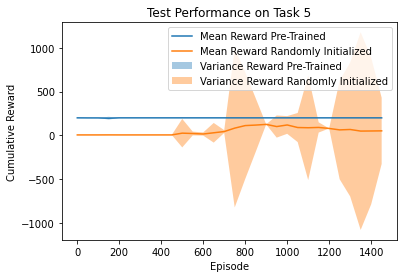

In [16]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    print(tasks[i])

    average = test_average_transfer_per_task[i] 
    variance = test_variance_transfer_per_task[i]
    plt.plot([50 * i for i in range(len(average))], average)
    plt.fill_between([50 * i for i in range(len(average))], average+variance, average-variance, alpha=0.4)
    
    average = test_average_scratch_per_task[i] 
    variance = test_variance_scratch_per_task[i]
    plt.plot([50 * i for i in range(len(average))], average)
    plt.fill_between([50 * i for i in range(len(average))], average+variance, average-variance, alpha=0.4)
    
    plt.title(f"Test Performance on Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
               'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'), loc=0)
    plt.savefig(os.path.join(plots_path, f'w_variance_test_on_task_{i+1}.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


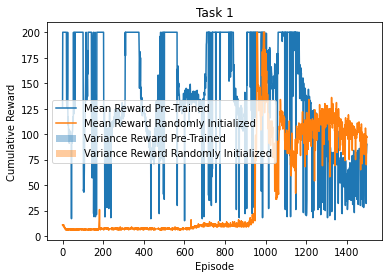

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


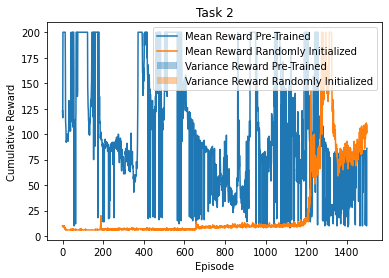

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


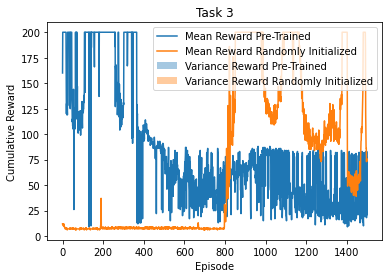

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


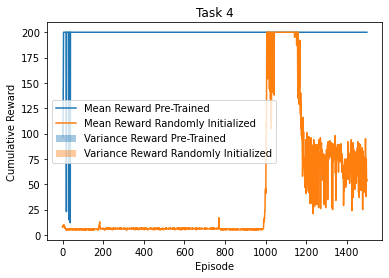

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


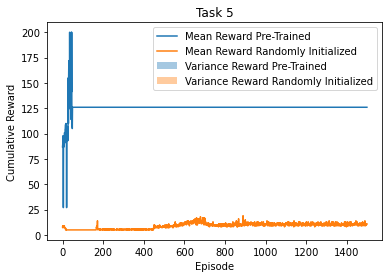

In [16]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    # plt.figure(figsize(12,6))
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_task_{i+1}.png'))
    plt.show()

In [ ]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [ ]:
env = ContinuousCartPoleEnv()

frames = []
for i in range(3):
    state = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(state, add_noise=False)
        state, r, done, _ = env.step(action)
        R += r
        t += 1
    
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())